Part 1 - Q2 - Classic ML Methods
===

I am going to implement, with and without features engineering:

*  Logistic Regression
*  Random Forest

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import tsfresh as tsf
from tsfresh import extract_features
import warnings

In [32]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [323]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [324]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [8]:
import custom_ecg_delineate as custom
reload(custom)
import custom_ecg_delineate as custom

In [326]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'cardinality': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 '0': '{:.0%}',
 '1': '{:.0%}',
 '1.0': '{:.0%}',
 '0.0': '{:.0%}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

In [27]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [11]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [21]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_heart_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
      dtype='int64', length=188)

In [14]:
df_heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11641 entries, 0 to 11640
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 16.7 MB


In [15]:
n_train_examples = df_heart_train.shape[0]
n_test_examples = df_heart_test.shape[0]
n_total_examples = n_train_examples + n_test_examples
print(f'The test split has {n_test_examples} rows, or {n_test_examples/n_total_examples:.2%} of all examples (which represent {n_total_examples} rows).')

The test split has 2911 rows, or 20.00% of all examples (which represent 14552 rows).


# Raw time series

## Minimal Features preprocessing

(No feature engineering)

In [60]:
# Type of columns
label_col = list(df_heart_train.columns)[-1]
num_features = list(df_heart_train.columns)[:-1]
categorical_features=[]
category_to_drop={}



In [25]:
# Create a list of indexes in each class
idx_by_class = {
		'0.0': [],
		'1.0': [],
}
for idx, row in df_heart_train.iterrows():
		if row[label_col] == 0.0:
			idx_by_class['0.0'].append(idx)
		elif row[label_col] == 1.0:
			idx_by_class['1.0'].append(idx)
		else:
			raise ValueError(f'Unexpected value {row[label_col]} in row {idx}.')

In [28]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'02b89f00-9964-4bcf-8bb9-d717d1df2a99': {'version…

In [35]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [36]:
train_test_data, final_categorical_features, all_features, _ = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=category_to_drop,
        label_col=label_col,
        add_one_hot_encoded=base.add_one_hot_encoded,
        add_embeddings=False,
        split_data=True,
        stand_features=base.stand_features,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        replace_pb_values={},
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [81]:
train_test_data.dataframes.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

In [40]:
X_train_df['all'].head(3)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
381,0.929947,0.977233,0.947110,0.809457,0.359370,0.103678,0.000000,0.053940,0.186340,0.309282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4453,0.940968,0.612751,0.164109,0.127509,0.069658,0.096812,0.112751,0.100354,0.085596,0.079693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1155,0.963608,0.525844,0.085443,0.000000,0.040084,0.039557,0.027426,0.036392,0.047996,0.068038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Working with the class imbalance

In [41]:
# From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

In [42]:
class_weights

[3.602321083172147, 1.3842723353649473]

## Model A: Logistic Regression

### Model Building

In [43]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [44]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs
     

     def compute_loss(self, y_pred, y_true):
         return F.binary_cross_entropy(y_pred, y_true)


     def compute_l1_loss(self, w):
         return torch.abs(w).sum()


def add_l1_loss( model, loss, lambda_lasso: float = 0.01):
    # TODO(pinolej): Check whether can be added to the class
    l1_parameters = []
    for parameter in model.parameters():
        l1_parameters.append(parameter.view(-1))
    l1 = lambda_lasso * model.compute_l1_loss(torch.cat(l1_parameters))
    # Add L1 loss component
    loss += l1
    return loss

    

### Training

In [45]:
pn.Column(
    pn.Row(base.param.use_lasso, base.param.use_focal_loss),
    pn.Row(base.param.lr_power, base.param.lr_multiple),
    pn.Row(base.param.lambda_power, base.param.lambda_multiple)
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'26823a92-e8fa-490b-a254-1ea1150c13c4': {'version…

In [46]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(base.lr_multiple, -base.lr_power, lr))
lambda_lasso = base.lambda_multiple * 10**(-base.lambda_power)
print('lambda_lasso is {} multiplied by 10 power {}, which yields {:.6f}'.format(base.lambda_multiple, -base.lambda_power, lambda_lasso))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000
lambda_lasso is 1 multiplied by 10 power -2, which yields 0.010000


In [61]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'70219e61-d03d-4e20-a453-3f73dad4fb34': {'version…

In [62]:
input_dim = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
model = LogisticRegression(input_dim,output_dim)
if base.use_focal_loss:
    criterion = FocalLoss(alpha=class_weights_tensor.long(), gamma=2)
else:
    criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

iter_printing_effective is 400


In [63]:
losses = []
losses_test = []
Iterations = []
iter = 0
model.train()
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train['all'])  # Perform forward pass
    loss = criterion(torch.squeeze(outputs), labels) # Compute loss
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    # Compute L1 loss component
    if base.use_lasso:
        loss = add_l1_loss(model, loss, lambda_lasso=lambda_lasso)

    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%base.iter_array==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test['all']))
            loss_test = criterion(outputs_test, y_test)
            loss_test = add_l1_loss(model, loss_test, lambda_lasso=lambda_lasso)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            if iter%iter_printing_effective==0:
                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  21%|██        | 411/2000 [00:06<00:26, 60.44it/s] 

Iteration: 400. 
Test - Loss: 0.3063903748989105. Accuracy: 66.63804207814513
Train -  Loss: 0.307067334651947. Accuracy: 66.96735395189003



Training Epochs:  41%|████      | 814/2000 [00:11<00:11, 106.80it/s]

Iteration: 800. 
Test - Loss: 0.29947954416275024. Accuracy: 68.82782310004293
Train -  Loss: 0.3005751669406891. Accuracy: 68.43857388316151



Training Epochs:  61%|██████    | 1213/2000 [00:16<00:12, 64.61it/s]

Iteration: 1200. 
Test - Loss: 0.2987200617790222. Accuracy: 69.81537140403607
Train -  Loss: 0.2999924421310425. Accuracy: 69.34063573883161



Training Epochs:  81%|████████  | 1614/2000 [00:22<00:04, 89.57it/s] 

Iteration: 1600. 
Test - Loss: 0.299869567155838. Accuracy: 70.50236152855302
Train -  Loss: 0.3012336194515228. Accuracy: 69.82388316151203



Training Epochs: 100%|██████████| 2000/2000 [00:31<00:00, 63.27it/s] 

Iteration: 2000. 
Test - Loss: 0.3014077842235565. Accuracy: 71.18935165306999
Train -  Loss: 0.3028232157230377. Accuracy: 70.66151202749141



Text(0, 0.5, 'Focal Loss')

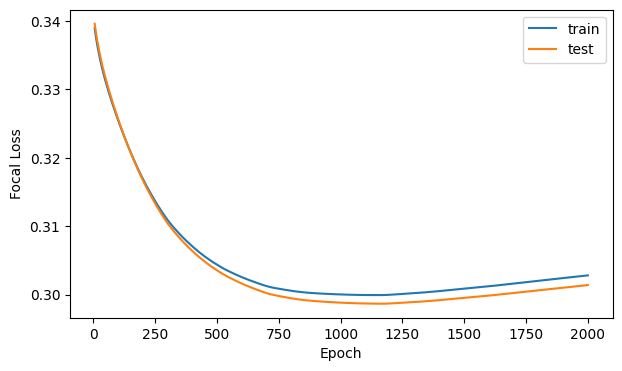

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

### Evaluation

#### Predictions performances

In [110]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'43080e47-4e08-4f88-91f9-3a28053558aa': {'version…

In [111]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    # 'all': {
    #     'data': df_heart,
    #     'already_processed': False,
    # },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [112]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x']
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=category_to_drop,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=False,
                stand_features=base.stand_features,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
								replace_pb_values={},
        )
        x_features = processed_data.tensors['X_train']['all']
        y_true = processed_data.tensors['y_train']

Processing data
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [113]:
model.eval()
y_pred_tensor = torch.squeeze(model(x_features))
y_pred_round_tensor = y_pred_tensor.round()
y_pred = y_pred_tensor.detach().numpy()
y_pred_round = y_pred_round_tensor.detach().numpy()

In [114]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [115]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,70.3%,74.3%,76.0%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

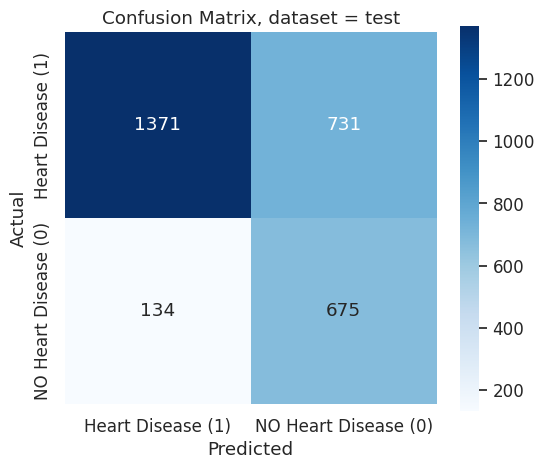

In [116]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [117]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [120]:
y_true.shape

torch.Size([2911])

In [121]:
y_pred.shape

(2911,)

In [122]:
y_pred_tensor

tensor([0.5180, 0.4637, 0.4493,  ..., 0.3466, 0.3982, 0.4988],
       grad_fn=<SqueezeBackward0>)

In [77]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:300: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


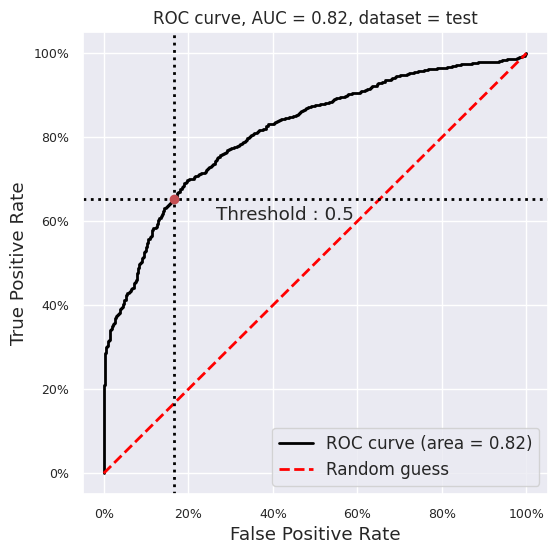

In [78]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

## Model B: Random Forest

### Model Building & Training

In [82]:
X_train_df, X_test_df = train_test_data.dataframes['X_train'], train_test_data.dataframes['X_test']
y_train_df, y_test_df = train_test_data.dataframes['y_train'], train_test_data.dataframes['y_test']

In [88]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(
	n_estimators = 100,
	random_state = 42,
	max_depth = 10,
	min_samples_split=2,
	min_samples_leaf=1,
	max_leaf_nodes=None,
	)
# Train the model on training data
rf.fit(X_train_df['all'], y_train_df)

RandomForestClassifier(max_depth=10, random_state=42)

Text(0, 0.5, 'Focal Loss')

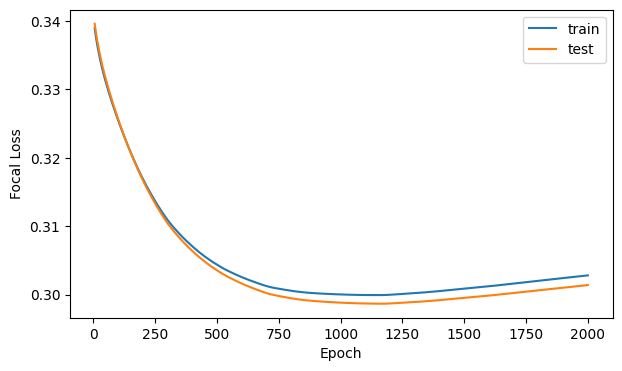

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

### Evaluation

#### Features Importance

linear.weight
linear.bias
tensor([[-8.0386e-02, -1.0491e-02,  1.2531e-01,  1.6605e-01,  2.2227e-01,
          8.7836e-02,  1.1329e-02,  1.8553e-02,  4.4660e-02,  5.7403e-03,
          4.7493e-02,  8.9444e-02,  5.8834e-02,  7.2757e-02, -6.1303e-05,
          9.8648e-02, -1.5356e-02,  3.2152e-02,  6.7850e-02,  8.1366e-03,
         -4.5026e-03,  2.8286e-02,  4.9527e-02, -5.0566e-02,  1.7823e-02,
         -2.6957e-02, -1.2402e-01, -1.4091e-01, -1.3290e-01, -6.3779e-02,
         -8.1037e-02, -2.0476e-01, -9.2633e-02, -1.8558e-01, -1.6481e-01,
         -9.5486e-02, -3.9673e-02, -3.6964e-02,  2.7505e-02,  2.4046e-03,
          1.0117e-02,  3.5068e-02,  6.1825e-02,  1.0761e-01,  1.1064e-02,
          1.2563e-01,  7.8604e-02,  1.0022e-02,  5.2478e-02,  2.3953e-02,
          3.5785e-02,  1.0928e-01,  3.3713e-02,  7.2422e-02,  1.1133e-01,
          3.8798e-02,  9.3746e-02,  4.6161e-02,  1.0019e-01,  1.1231e-01,
          1.0632e-02,  6.4883e-02,  5.7174e-02,  8.1257e-02,  1.2032e-02,
          6.

<Axes: ylabel='Feature'>

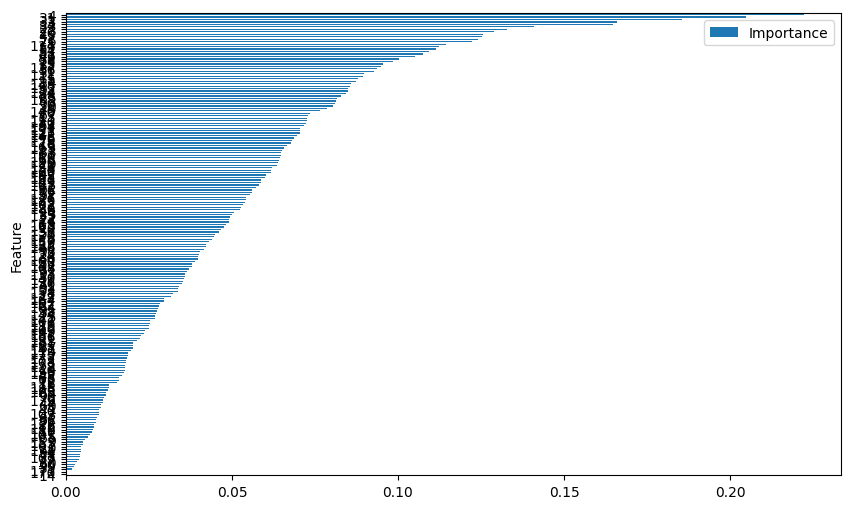

In [ ]:
for name, model_param in model.named_parameters():
    print(name)
    if name == 'linear.weight':
        weights = model_param.data
print(weights)
coefficients = weights.detach().numpy()
feature_importance = pd.DataFrame({'Feature': X_train_df['all'].columns, 'Importance': np.abs(coefficients.flatten())})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

linear.weight
linear.bias
tensor([[-8.0386e-02, -1.0491e-02,  1.2531e-01,  1.6605e-01,  2.2227e-01,
          8.7836e-02,  1.1329e-02,  1.8553e-02,  4.4660e-02,  5.7403e-03,
          4.7493e-02,  8.9444e-02,  5.8834e-02,  7.2757e-02, -6.1303e-05,
          9.8648e-02, -1.5356e-02,  3.2152e-02,  6.7850e-02,  8.1366e-03,
         -4.5026e-03,  2.8286e-02,  4.9527e-02, -5.0566e-02,  1.7823e-02,
         -2.6957e-02, -1.2402e-01, -1.4091e-01, -1.3290e-01, -6.3779e-02,
         -8.1037e-02, -2.0476e-01, -9.2633e-02, -1.8558e-01, -1.6481e-01,
         -9.5486e-02, -3.9673e-02, -3.6964e-02,  2.7505e-02,  2.4046e-03,
          1.0117e-02,  3.5068e-02,  6.1825e-02,  1.0761e-01,  1.1064e-02,
          1.2563e-01,  7.8604e-02,  1.0022e-02,  5.2478e-02,  2.3953e-02,
          3.5785e-02,  1.0928e-01,  3.3713e-02,  7.2422e-02,  1.1133e-01,
          3.8798e-02,  9.3746e-02,  4.6161e-02,  1.0019e-01,  1.1231e-01,
          1.0632e-02,  6.4883e-02,  5.7174e-02,  8.1257e-02,  1.2032e-02,
          6.

<Axes: ylabel='Feature'>

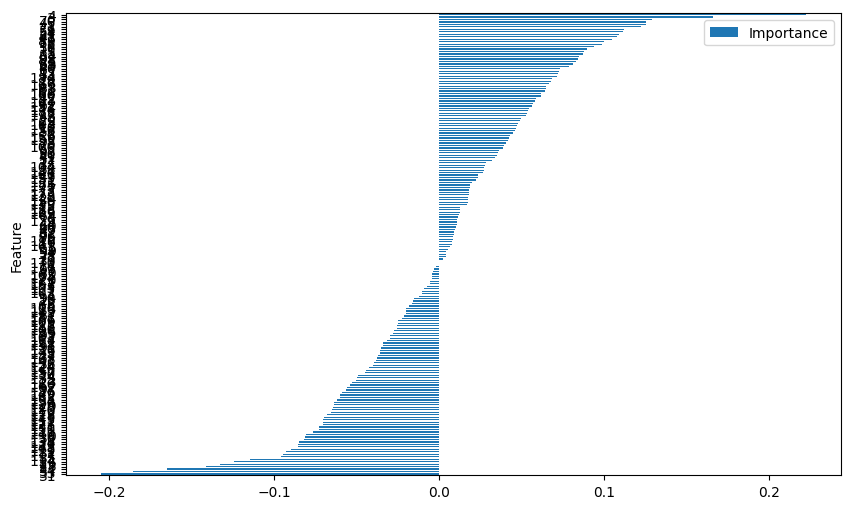

In [ ]:
for name, model_param in model.named_parameters():
    print(name)
    if name == 'linear.weight':
        weights = model_param.data
print(weights)
coefficients = weights.detach().numpy()
feature_importance = pd.DataFrame({'Feature': X_train_df['all'].columns, 'Importance': coefficients.flatten()})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

#### Predictions performances

In [123]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d84d5b2b-ea3b-4f1f-b19d-215db4ae64fa': {'version…

In [124]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    # 'all': {
    #     'data': df_heart,
    #     'already_processed': False,
    # },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [128]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x']
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=category_to_drop,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=False,
                stand_features=base.stand_features,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
								replace_pb_values={},
        )
        x_features = processed_data.dataframes['X_train']['all']
        y_true = torch.tensor(processed_data.dataframes['y_train'].values)

Processing data
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [129]:
# model.eval()
# y_pred_tensor = torch.squeeze(model(x_features))
# y_pred_round_tensor = y_pred_tensor.round()
# y_pred = y_pred_tensor.detach().numpy()
# y_pred_round = y_pred_round_tensor.detach().numpy()

In [147]:
y_pred = rf.predict_proba(x_features)[:,1]
y_pred_tensor = torch.from_numpy(y_pred)
y_pred_round = rf.predict(x_features)
y_pred_round_tensor = torch.from_numpy(y_pred_round)

In [148]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [149]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,94.1%,92.7%,95.9%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

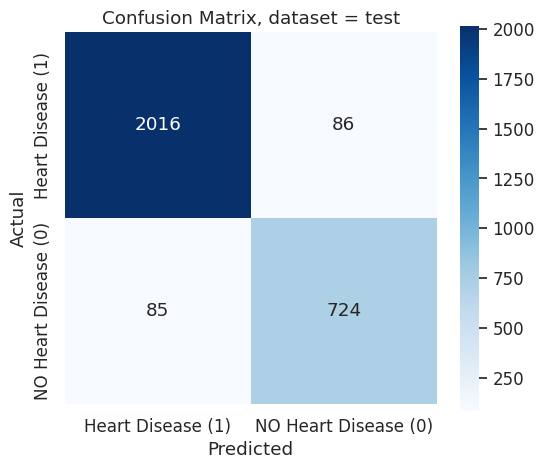

In [150]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [151]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [153]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:300: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


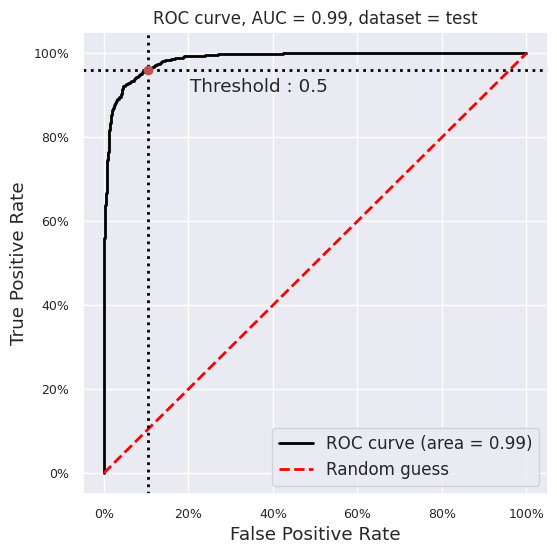

In [154]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# WITH Features Design & Engineering

## Features preprocessing



I am importing the data produced in the exploratory notebook [xxx add link]

In [155]:
# Load the ts fresh transformed features
tsf_fresh_features = lib.join_all_features_csv_batches(
    dir_path='../output/cs_files_tsfresh/',
    pull_all=True,
)

../output/cs_files_tsfresh/*.csv
../output/cs_files_tsfresh/extracted_features_9550_9599.csv
../output/cs_files_tsfresh/extracted_features_4700_4749.csv
../output/cs_files_tsfresh/extracted_features_5900_5949.csv
../output/cs_files_tsfresh/extracted_features_6200_6249.csv
../output/cs_files_tsfresh/extracted_features_11250_11299.csv
../output/cs_files_tsfresh/extracted_features_400_449.csv
../output/cs_files_tsfresh/extracted_features_5500_5549.csv
../output/cs_files_tsfresh/extracted_features_10550_10599.csv
../output/cs_files_tsfresh/extracted_features_1550_1599.csv
../output/cs_files_tsfresh/extracted_features_6700_6749.csv
../output/cs_files_tsfresh/extracted_features_7000_7049.csv
../output/cs_files_tsfresh/extracted_features_1250_1299.csv
../output/cs_files_tsfresh/extracted_features_8600_8649.csv
../output/cs_files_tsfresh/extracted_features_900_949.csv
../output/cs_files_tsfresh/extracted_features_8250_8299.csv
../output/cs_files_tsfresh/extracted_features_8000_8049.csv
../outp

In [322]:
print(f'Comparing the # heartbeats in the original dataset and in the processed one')
print(f'Originally: {df_heart_train.shape[0]} heartbeats')
print(f'After ts fresh processing: {tsf_fresh_features.shape[0]} heartbeats')
print(f'Is it the same? {tsf_fresh_features.shape[0] == df_heart_train.shape[0]}')

Comparing the # heartbeats in the original dataset and in the processed one
Originally: 11641 heartbeats
After ts fresh processing: 11641 heartbeats
Is it the same? True


In [157]:
tsf_fresh_features.head(3)

,variance_larger_than_standard_deviation,has_duplicate_max,has_duplicate_min,has_duplicate,sum_values,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,...,fourier_entropy__bins_5,fourier_entropy__bins_10,fourier_entropy__bins_100,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,query_similarity_count__query_None__threshold_0.0,mean_n_absolute_max__number_of_maxima_7
heartbeat_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,1.0,31.761560,8.927965,0.014062,-0.005376,0.000728,0.178528,...,0.161651,0.316683,0.974941,1.566183,2.558113,3.418415,3.910249,4.101044,NaN,0.602734
1,0.0,0.0,1.0,1.0,21.162685,7.935466,0.032056,-0.005376,0.002291,0.000000,...,0.117714,0.176399,1.274168,1.105742,1.719584,2.258974,2.581583,2.731673,NaN,0.669755
2,0.0,0.0,1.0,1.0,18.361812,5.907348,0.022110,-0.005247,0.000764,0.071674,...,0.853715,1.276388,2.616993,1.230186,1.766055,2.281631,2.684533,2.957541,NaN,0.692661


**First preprocessing**:
*  We are going to remove columns that have mostly nan values, they make up 30 columns out of 783. We are then left with 753 columns.
*  I am removing the columns with only one value as they are non-informative. We are going down to 711 columns.

In [168]:
tsf_fresh_features.isna().sum().sort_values(ascending=False).value_counts()

0        753
11641     25
11580      5
Name: count, dtype: int64

In [240]:
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [241]:
tsf_fresh_features_processed = lib.some_features_selection(
	tsf_fresh_features,
	thresholds_n_nan=100,
)

In [242]:
tsf_fresh_features_processed.shape

(11641, 711)

In [ ]:
tsf_fresh_features_processed.columns

Index(['variance_larger_than_standard_deviation', 'has_duplicate_max',
       'has_duplicate_min', 'has_duplicate', 'sum_values', 'abs_energy',
       'mean_abs_change', 'mean_change', 'mean_second_derivative_central',
       'median',
       ...
       'fourier_entropy__bins_3', 'fourier_entropy__bins_5',
       'fourier_entropy__bins_10', 'fourier_entropy__bins_100',
       'permutation_entropy__dimension_3__tau_1',
       'permutation_entropy__dimension_4__tau_1',
       'permutation_entropy__dimension_5__tau_1',
       'permutation_entropy__dimension_6__tau_1',
       'permutation_entropy__dimension_7__tau_1',
       'mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=753)

In [243]:
features_infos = lib.features_information(tsf_fresh_features_processed)

*  Features with a cardinality of 2 are clearly categorical.
*  At the 20-th percentile, we already reach more than 10k values => we can be confident those are continuous features.
* What about the features with small cardinality?

In [327]:
features_infos.describe(percentiles=[0.025, 0.03, 0.035, 0.04, 0.05, 0.1]).style.format(format_dict)

,cardinality
count,711
mean,10278
std,3547
min,2
2.5%,2
3%,4
3.5%,14
4%,20
5%,31
10%,1555


In [251]:
features_infos.iloc[-32:-15]

,cardinality
number_peaks__n_3,22
lempel_ziv_complexity__bins_2,21
number_cwt_peaks__n_5,21
ratio_beyond_r_sigma__r_2.5,20
"augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",16
number_peaks__n_5,15
ratio_beyond_r_sigma__r_3,15
number_peaks__n_10,9
ratio_beyond_r_sigma__r_5,6
ratio_beyond_r_sigma__r_6,5


In [252]:
features_infos[(features_infos['cardinality'] > 2) & (features_infos['cardinality'] < 16)]

,cardinality
number_peaks__n_5,15
ratio_beyond_r_sigma__r_3,15
number_peaks__n_10,9
ratio_beyond_r_sigma__r_5,6
ratio_beyond_r_sigma__r_6,5
ratio_beyond_r_sigma__r_7,4
number_crossing_m__m_0,3
number_peaks__n_50,3


In [253]:
cols_to_plot = list(features_infos[(features_infos['cardinality'] > 2) & (features_infos['cardinality'] < 16)].index)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  def plot_superposed_heartbeats(


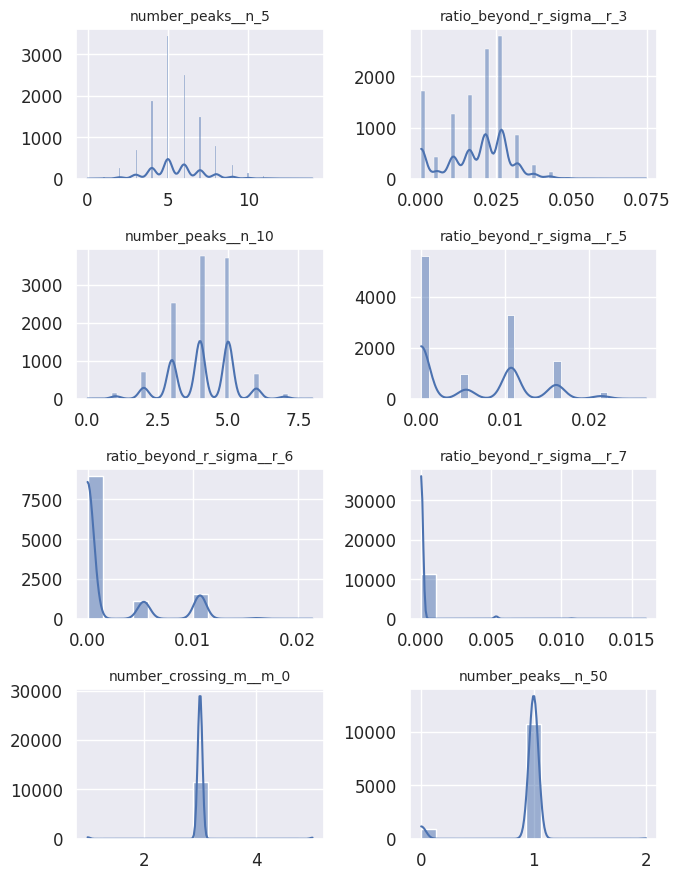

In [254]:
gr.dist_mult_plots(
    tsf_fresh_features_processed,
    cols=cols_to_plot,
    figsize=(7, 9),
    ncols=2,
    fontsize={
        'ax_title': 10,
    },
    # custom_bins={'FastingBS': 60},
)

**Conclusion of the plots**

Except for the last 3 plots, with the smallest cardinality, I will keep those features as numerical, both because the range looks like it makes sense, and because the titles seem to refer to numerical features (not necessarily continuous, for instance `number_peaks__n_10`, but even then, it can make sense that the effect is some function of the distance between each values).

In [255]:
cols_to_plot = list(features_infos[(features_infos['cardinality'] < 5) & (features_infos['cardinality'] > 2)].index)

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  def plot_superposed_heartbeats(


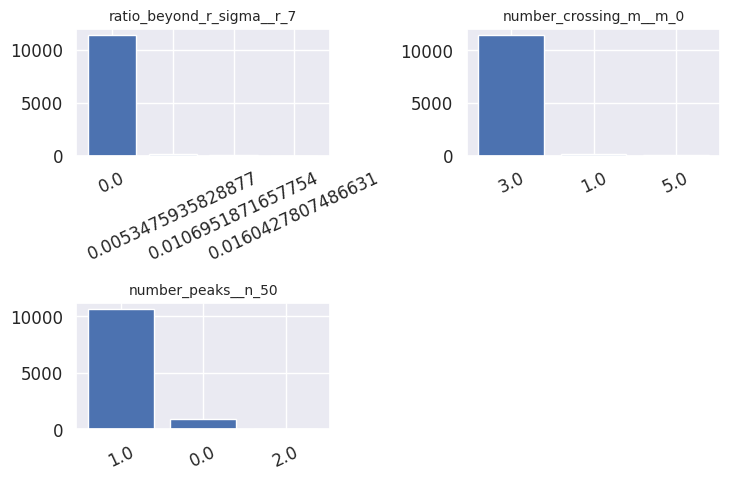

In [256]:
gr.dist_mult_plots(
    tsf_fresh_features_processed,
    cols=cols_to_plot,
    figsize=(7.5, 5),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
		rotate_bar_ticks=25,
)

**Conclusion of the last 3 plots**

The imbalance between classes and the small number of classes make me choose to consider these features as categorical, even though they could also be interpreted as numerical.

Now, I am joining the label column, to use the preprocessing function `pre_process_features(.)`.

In [273]:
labels_vector = df_heart_train.iloc[:,-1]
features_and_labels = pd.merge(labels_vector, tsf_fresh_features_processed, left_index=True, right_index=True, how='outer')
features_and_labels = features_and_labels.rename(columns={df_heart_train.iloc[:,-1].name: 'labels'})

In [274]:
features_and_labels.head(3)

,labels,has_duplicate_max,sum_values,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,mean,standard_deviation,...,fourier_entropy__bins_3,fourier_entropy__bins_5,fourier_entropy__bins_10,fourier_entropy__bins_100,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,31.761560,8.927965,0.014062,-0.005376,0.000728,0.178528,0.169848,0.137458,...,0.141337,0.161651,0.316683,0.974941,1.566183,2.558113,3.418415,3.910249,4.101044,0.602734
1,1.0,0.0,21.162685,7.935466,0.032056,-0.005376,0.002291,0.000000,0.113169,0.172129,...,0.117714,0.117714,0.176399,1.274168,1.105742,1.719584,2.258974,2.581583,2.731673,0.669755
2,0.0,0.0,18.361812,5.907348,0.022110,-0.005247,0.000764,0.071674,0.098192,0.148150,...,0.551940,0.853715,1.276388,2.616993,1.230186,1.766055,2.281631,2.684533,2.957541,0.692661


In [272]:
features_and_labels.columns[0]

187

In [259]:
tsf_fresh_features_processed.shape

(11641, 711)

In [283]:
# Benchmark to be dropped for each categorical variable
category_to_drop = {
    'ratio_beyond_r_sigma__r_7': '0.0',
    'number_peaks__n_50': '1.0',
    'number_crossing_m__m_0': '3.0',
}
num_features = list(features_infos[(features_infos['cardinality'] >= 5)].index)
categorical_features = list(features_infos[(features_infos['cardinality'] < 5)].index)

In [284]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'371921f6-0da6-4ea3-9411-eec04cf22407': {'version…

In [285]:
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [288]:
train_test_data, final_categorical_features, all_features, _ = lib.pre_process_features(
        features_and_labels,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=category_to_drop,
        label_col='labels',
        add_one_hot_encoded=True,
        add_embeddings=False,
        split_data=True,
        stand_features=True,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        replace_pb_values={
				},
)

X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

adding One Hot Encoded
['fft_coefficient__attr_"imag"__coeff_31', 'fft_coefficient__attr_"imag"__coeff_55', 'fft_coefficient__attr_"imag"__coeff_49', 'fft_coefficient__attr_"imag"__coeff_50', 'fft_coefficient__attr_"imag"__coeff_51', 'fft_coefficient__attr_"imag"__coeff_52', 'fft_coefficient__attr_"imag"__coeff_53', 'fft_coefficient__attr_"imag"__coeff_54', 'fft_coefficient__attr_"imag"__coeff_56', 'fft_coefficient__attr_"imag"__coeff_47', 'fft_coefficient__attr_"imag"__coeff_57', 'fft_coefficient__attr_"imag"__coeff_58', 'fft_coefficient__attr_"imag"__coeff_59', 'fft_coefficient__attr_"imag"__coeff_60', 'fft_coefficient__attr_"imag"__coeff_61', 'fft_coefficient__attr_"imag"__coeff_62', 'fft_coefficient__attr_"imag"__coeff_48', 'fft_coefficient__attr_"imag"__coeff_46', 'fft_coefficient__attr_"imag"__coeff_29', 'fft_coefficient__attr_"imag"__coeff_37', 'sum_values', 'fft_coefficient__attr_"imag"__coeff_32', 'fft_coefficient__attr_"imag"__coeff_33', 'fft_coefficient__attr_"imag"__coeff_3

In [289]:
X_train_df['all'].head(3)

,"fft_coefficient__attr_""imag""__coeff_31","fft_coefficient__attr_""imag""__coeff_55","fft_coefficient__attr_""imag""__coeff_49","fft_coefficient__attr_""imag""__coeff_50","fft_coefficient__attr_""imag""__coeff_51","fft_coefficient__attr_""imag""__coeff_52","fft_coefficient__attr_""imag""__coeff_53","fft_coefficient__attr_""imag""__coeff_54","fft_coefficient__attr_""imag""__coeff_56","fft_coefficient__attr_""imag""__coeff_47",...,symmetry_looking__r_0.15000000000000002_0.0,symmetry_looking__r_0.15000000000000002_1.0,symmetry_looking__r_0.2_0.0,symmetry_looking__r_0.2_1.0,symmetry_looking__r_0.25_0.0,symmetry_looking__r_0.25_1.0,symmetry_looking__r_0.30000000000000004_0.0,symmetry_looking__r_0.30000000000000004_1.0,has_duplicate_max_0.0,has_duplicate_max_1.0
381,0.456936,0.527275,0.417949,0.648392,0.399161,0.660136,0.425989,0.647409,0.486729,0.455927,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4453,0.366706,0.459945,0.553261,0.352978,0.533302,0.442404,0.484326,0.543295,0.527730,0.417348,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1155,0.391440,0.506483,0.405649,0.615233,0.340402,0.453673,0.571679,0.405020,0.491169,0.516942,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


### Working with the class imbalance

In [290]:
# From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

In [291]:
class_weights

[3.602321083172147, 1.3842723353649473]

## Model A: Logistic Regression

### Model Building

In [292]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [293]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs
     

     def compute_loss(self, y_pred, y_true):
         return F.binary_cross_entropy(y_pred, y_true)


     def compute_l1_loss(self, w):
         return torch.abs(w).sum()


def add_l1_loss( model, loss, lambda_lasso: float = 0.01):
    # TODO(pinolej): Check whether can be added to the class
    l1_parameters = []
    for parameter in model.parameters():
        l1_parameters.append(parameter.view(-1))
    l1 = lambda_lasso * model.compute_l1_loss(torch.cat(l1_parameters))
    # Add L1 loss component
    loss += l1
    return loss

    

### Training

In [294]:
pn.Column(
    pn.Row(base.param.use_lasso, base.param.use_focal_loss),
    pn.Row(base.param.lr_power, base.param.lr_multiple),
    pn.Row(base.param.lambda_power, base.param.lambda_multiple)
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'f52ba4cb-168c-4f6d-9107-97cd877bea4f': {'version…

In [295]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(base.lr_multiple, -base.lr_power, lr))
lambda_lasso = base.lambda_multiple * 10**(-base.lambda_power)
print('lambda_lasso is {} multiplied by 10 power {}, which yields {:.6f}'.format(base.lambda_multiple, -base.lambda_power, lambda_lasso))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000
lambda_lasso is 1 multiplied by 10 power -2, which yields 0.010000


In [296]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

BokehModel(combine_events=True, render_bundle={'docs_json': {'7117bdbb-9dad-4b75-962c-5558d6556748': {'version…

In [297]:
input_dim = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
model = LogisticRegression(input_dim,output_dim)
if base.use_focal_loss:
    criterion = FocalLoss(alpha=class_weights_tensor.long(), gamma=2)
else:
    criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

iter_printing_effective is 400


In [298]:
losses = []
losses_test = []
Iterations = []
iter = 0
model.train()
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train['all'])  # Perform forward pass
    loss = criterion(torch.squeeze(outputs), labels) # Compute loss
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    # Compute L1 loss component
    if base.use_lasso:
        loss = add_l1_loss(model, loss, lambda_lasso=lambda_lasso)

    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%base.iter_array==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test['all']))
            loss_test = criterion(outputs_test, y_test)
            loss_test = add_l1_loss(model, loss_test, lambda_lasso=lambda_lasso)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            if iter%iter_printing_effective==0:
                print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:   0%|          | 5/2000 [00:00<02:28, 13.44it/s]

Training Epochs:  21%|██        | 418/2000 [00:08<00:18, 86.93it/s]

Iteration: 400. 
Test - Loss: 0.3530476689338684. Accuracy: 67.45384285100901
Train -  Loss: 0.3538585901260376. Accuracy: 66.72036082474227



Training Epochs:  40%|████      | 803/2000 [00:15<00:22, 52.38it/s]

Iteration: 800. 
Test - Loss: 0.35047245025634766. Accuracy: 73.76556462000859
Train -  Loss: 0.35189491510391235. Accuracy: 73.05627147766323



Training Epochs:  60%|██████    | 1210/2000 [00:22<00:11, 71.59it/s]

Iteration: 1200. 
Test - Loss: 0.3563956618309021. Accuracy: 77.97337913267496
Train -  Loss: 0.3581267297267914. Accuracy: 76.63230240549828



Training Epochs:  81%|████████  | 1618/2000 [00:29<00:04, 81.39it/s] 

Iteration: 1600. 
Test - Loss: 0.36472922563552856. Accuracy: 79.94847574066122
Train -  Loss: 0.3665819466114044. Accuracy: 79.1344501718213



Training Epochs: 100%|██████████| 2000/2000 [00:36<00:00, 54.96it/s]

Iteration: 2000. 
Test - Loss: 0.3737099766731262. Accuracy: 81.83769858308287
Train -  Loss: 0.37557750940322876. Accuracy: 80.63788659793815



Text(0, 0.5, 'Focal Loss')

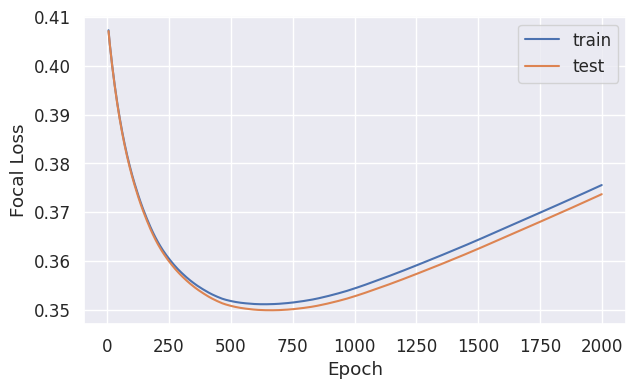

In [299]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

### Evaluation

#### Predictions performances

In [302]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'13688ea5-bdde-4e74-bdf5-7f1a30a6ca3f': {'version…

In [301]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    # 'all': {
    #     'data': df_heart,
    #     'already_processed': False,
    # },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [303]:
# Load the ts fresh transformed features
tsf_fresh_features_eval = lib.join_all_features_csv_batches(
    dir_path='../output/eval/cs_files_tsfresh/',
    pull_all=True,
)

../output/eval/cs_files_tsfresh/*.csv
../output/eval/cs_files_tsfresh/extracted_features_2200_2299.csv


../output/eval/cs_files_tsfresh/extracted_features_1100_1199.csv
../output/eval/cs_files_tsfresh/extracted_features_2100_2199.csv
../output/eval/cs_files_tsfresh/extracted_features_800_899.csv
../output/eval/cs_files_tsfresh/extracted_features_300_399.csv
../output/eval/cs_files_tsfresh/extracted_features_2300_2399.csv
../output/eval/cs_files_tsfresh/extracted_features_2700_2799.csv
../output/eval/cs_files_tsfresh/extracted_features_2800_2899.csv
../output/eval/cs_files_tsfresh/extracted_features_2600_2699.csv
../output/eval/cs_files_tsfresh/extracted_features_900_999.csv
../output/eval/cs_files_tsfresh/extracted_features_1000_1099.csv
../output/eval/cs_files_tsfresh/extracted_features_700_799.csv
../output/eval/cs_files_tsfresh/extracted_features_1800_1899.csv
../output/eval/cs_files_tsfresh/extracted_features_1900_1999.csv
../output/eval/cs_files_tsfresh/extracted_features_2400_2499.csv
../output/eval/cs_files_tsfresh/extracted_features_500_599.csv
../output/eval/cs_files_tsfresh/ext

In [319]:
tsf_fresh_features_eval.head(3)

,variance_larger_than_standard_deviation,has_duplicate_max,has_duplicate_min,has_duplicate,sum_values,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,...,fourier_entropy__bins_5,fourier_entropy__bins_10,fourier_entropy__bins_100,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,query_similarity_count__query_None__threshold_0.0,mean_n_absolute_max__number_of_maxima_7
heartbeat_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,1.0,24.326751,9.193389,0.022942,-0.005118,-0.000130,0.103949,...,0.439242,0.877669,1.843505,1.117574,1.635885,2.093365,2.435852,2.635171,NaN,0.826645
1,0.0,0.0,1.0,1.0,13.184956,4.782169,0.018857,-0.005376,0.000906,0.039401,...,0.863675,1.256490,2.327013,1.228464,1.710874,2.132544,2.493482,2.758154,NaN,0.711867
2,0.0,0.0,1.0,1.0,28.723350,9.360617,0.023761,-0.005376,0.000636,0.167090,...,0.737410,1.171685,2.254856,1.169231,1.784212,2.311976,2.723344,2.976031,NaN,0.734046


In [321]:
print(f'Comparing the # heartbeats in the original dataset and in the processed one')
print(f'Originally: {df_heart_test.shape[0]} heartbeats')
print(f'After ts fresh processing: {tsf_fresh_features_eval.shape[0]} heartbeats')
print(f'Is it the same? {tsf_fresh_features_eval.shape[0] == df_heart_test.shape[0]}')

Comparing the # heartbeats in the original dataset and in the processed one
Originally: 2911 heartbeats
After ts fresh processing: 2911 heartbeats
Is it the same? True


In [305]:
tsf_fresh_features_processed_eval = lib.some_features_selection(
	tsf_fresh_features_eval,
	thresholds_n_nan=100,
)

In [307]:
tsf_fresh_features_processed_eval.shape

(2911, 711)

In [308]:
tsf_fresh_features_processed_eval.columns

Index(['has_duplicate_max', 'sum_values', 'abs_energy', 'mean_abs_change',
       'mean_change', 'mean_second_derivative_central', 'median', 'mean',
       'standard_deviation', 'variation_coefficient',
       ...
       'fourier_entropy__bins_3', 'fourier_entropy__bins_5',
       'fourier_entropy__bins_10', 'fourier_entropy__bins_100',
       'permutation_entropy__dimension_3__tau_1',
       'permutation_entropy__dimension_4__tau_1',
       'permutation_entropy__dimension_5__tau_1',
       'permutation_entropy__dimension_6__tau_1',
       'permutation_entropy__dimension_7__tau_1',
       'mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=711)

In [309]:
labels_vector = df_heart_test.iloc[:,-1]
features_and_labels_eval = pd.merge(labels_vector, tsf_fresh_features_processed_eval, left_index=True, right_index=True, how='outer')
features_and_labels_eval = features_and_labels_eval.rename(columns={df_heart_train.iloc[:,-1].name: 'labels'})
features_and_labels_eval.head(3)

,labels,has_duplicate_max,sum_values,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,mean,standard_deviation,...,fourier_entropy__bins_3,fourier_entropy__bins_5,fourier_entropy__bins_10,fourier_entropy__bins_100,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,24.326751,9.193389,0.022942,-0.005118,-0.000130,0.103949,0.130090,0.179553,...,0.295587,0.439242,0.877669,1.843505,1.117574,1.635885,2.093365,2.435852,2.635171,0.826645
1,1.0,0.0,13.184956,4.782169,0.018857,-0.005376,0.000906,0.039401,0.070508,0.143533,...,0.643162,0.863675,1.256490,2.327013,1.228464,1.710874,2.132544,2.493482,2.758154,0.711867
2,0.0,0.0,28.723350,9.360617,0.023761,-0.005376,0.000636,0.167090,0.153601,0.162676,...,0.476571,0.737410,1.171685,2.254856,1.169231,1.784212,2.311976,2.723344,2.976031,0.734046


In [311]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x']
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                features_and_labels_eval,
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=category_to_drop,
                label_col='labels',
                add_one_hot_encoded=True,
                add_embeddings=False,
                stand_features=True,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
								replace_pb_values={},
        )
        x_features = processed_data.tensors['X_train']['all']
        y_true = processed_data.tensors['y_train']

Processing data
adding One Hot Encoded
['fft_coefficient__attr_"imag"__coeff_31', 'fft_coefficient__attr_"imag"__coeff_55', 'fft_coefficient__attr_"imag"__coeff_49', 'fft_coefficient__attr_"imag"__coeff_50', 'fft_coefficient__attr_"imag"__coeff_51', 'fft_coefficient__attr_"imag"__coeff_52', 'fft_coefficient__attr_"imag"__coeff_53', 'fft_coefficient__attr_"imag"__coeff_54', 'fft_coefficient__attr_"imag"__coeff_56', 'fft_coefficient__attr_"imag"__coeff_47', 'fft_coefficient__attr_"imag"__coeff_57', 'fft_coefficient__attr_"imag"__coeff_58', 'fft_coefficient__attr_"imag"__coeff_59', 'fft_coefficient__attr_"imag"__coeff_60', 'fft_coefficient__attr_"imag"__coeff_61', 'fft_coefficient__attr_"imag"__coeff_62', 'fft_coefficient__attr_"imag"__coeff_48', 'fft_coefficient__attr_"imag"__coeff_46', 'fft_coefficient__attr_"imag"__coeff_29', 'fft_coefficient__attr_"imag"__coeff_37', 'sum_values', 'fft_coefficient__attr_"imag"__coeff_32', 'fft_coefficient__attr_"imag"__coeff_33', 'fft_coefficient__attr

In [312]:
model.eval()
y_pred_tensor = torch.squeeze(model(x_features))
y_pred_round_tensor = y_pred_tensor.round()
y_pred = y_pred_tensor.detach().numpy()
y_pred_round = y_pred_round_tensor.detach().numpy()

In [313]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [314]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,83.8%,85.1%,88.0%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

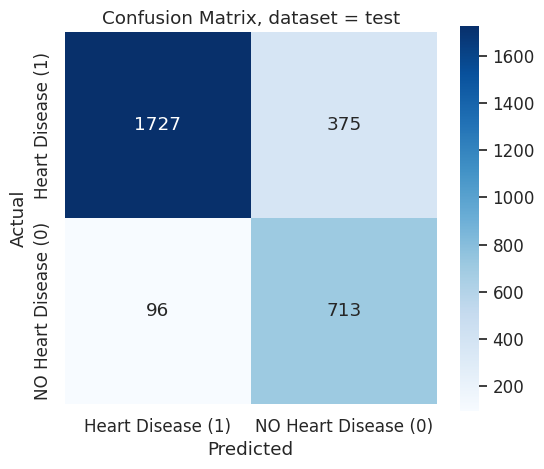

In [315]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [316]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [317]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:303: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.legend(loc=loc_legend)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:305: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


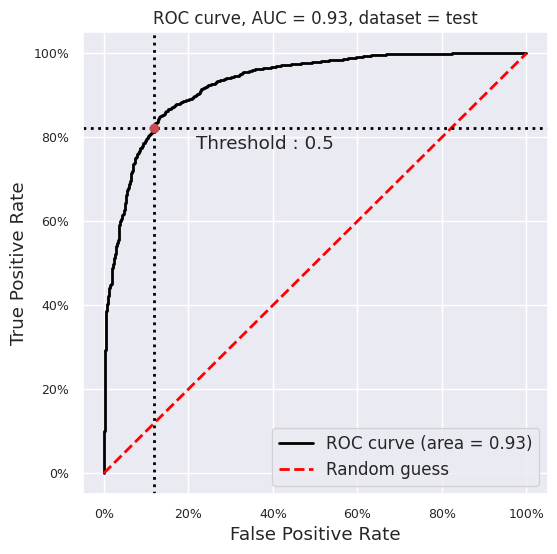

In [318]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

## Model B: Random Forest

### Model Building & Training

In [ ]:
X_train_df, X_test_df = train_test_data.dataframes['X_train'], train_test_data.dataframes['X_test']
y_train_df, y_test_df = train_test_data.dataframes['y_train'], train_test_data.dataframes['y_test']

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(
	n_estimators = 100,
	random_state = 42,
	max_depth = 10,
	min_samples_split=2,
	min_samples_leaf=1,
	max_leaf_nodes=None,
	)
# Train the model on training data
rf.fit(X_train_df['all'], y_train_df)

RandomForestClassifier(max_depth=10, random_state=42)

Text(0, 0.5, 'Focal Loss')

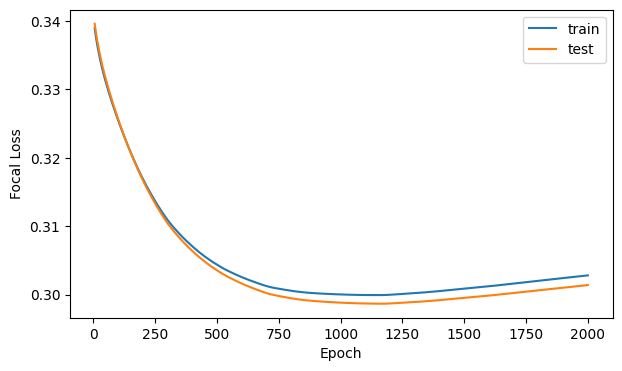

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

### Evaluation

#### Features Importance

linear.weight
linear.bias
tensor([[-8.0386e-02, -1.0491e-02,  1.2531e-01,  1.6605e-01,  2.2227e-01,
          8.7836e-02,  1.1329e-02,  1.8553e-02,  4.4660e-02,  5.7403e-03,
          4.7493e-02,  8.9444e-02,  5.8834e-02,  7.2757e-02, -6.1303e-05,
          9.8648e-02, -1.5356e-02,  3.2152e-02,  6.7850e-02,  8.1366e-03,
         -4.5026e-03,  2.8286e-02,  4.9527e-02, -5.0566e-02,  1.7823e-02,
         -2.6957e-02, -1.2402e-01, -1.4091e-01, -1.3290e-01, -6.3779e-02,
         -8.1037e-02, -2.0476e-01, -9.2633e-02, -1.8558e-01, -1.6481e-01,
         -9.5486e-02, -3.9673e-02, -3.6964e-02,  2.7505e-02,  2.4046e-03,
          1.0117e-02,  3.5068e-02,  6.1825e-02,  1.0761e-01,  1.1064e-02,
          1.2563e-01,  7.8604e-02,  1.0022e-02,  5.2478e-02,  2.3953e-02,
          3.5785e-02,  1.0928e-01,  3.3713e-02,  7.2422e-02,  1.1133e-01,
          3.8798e-02,  9.3746e-02,  4.6161e-02,  1.0019e-01,  1.1231e-01,
          1.0632e-02,  6.4883e-02,  5.7174e-02,  8.1257e-02,  1.2032e-02,
          6.

<Axes: ylabel='Feature'>

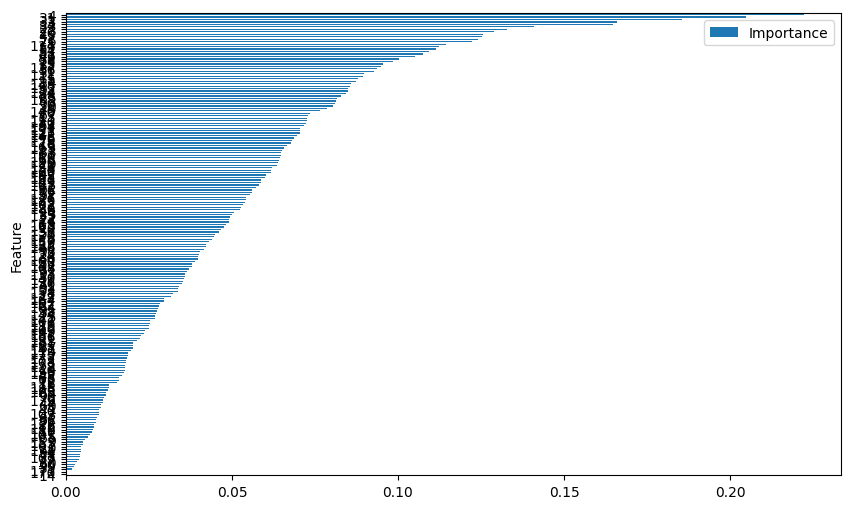

In [ ]:
for name, model_param in model.named_parameters():
    print(name)
    if name == 'linear.weight':
        weights = model_param.data
print(weights)
coefficients = weights.detach().numpy()
feature_importance = pd.DataFrame({'Feature': X_train_df['all'].columns, 'Importance': np.abs(coefficients.flatten())})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

linear.weight
linear.bias
tensor([[-8.0386e-02, -1.0491e-02,  1.2531e-01,  1.6605e-01,  2.2227e-01,
          8.7836e-02,  1.1329e-02,  1.8553e-02,  4.4660e-02,  5.7403e-03,
          4.7493e-02,  8.9444e-02,  5.8834e-02,  7.2757e-02, -6.1303e-05,
          9.8648e-02, -1.5356e-02,  3.2152e-02,  6.7850e-02,  8.1366e-03,
         -4.5026e-03,  2.8286e-02,  4.9527e-02, -5.0566e-02,  1.7823e-02,
         -2.6957e-02, -1.2402e-01, -1.4091e-01, -1.3290e-01, -6.3779e-02,
         -8.1037e-02, -2.0476e-01, -9.2633e-02, -1.8558e-01, -1.6481e-01,
         -9.5486e-02, -3.9673e-02, -3.6964e-02,  2.7505e-02,  2.4046e-03,
          1.0117e-02,  3.5068e-02,  6.1825e-02,  1.0761e-01,  1.1064e-02,
          1.2563e-01,  7.8604e-02,  1.0022e-02,  5.2478e-02,  2.3953e-02,
          3.5785e-02,  1.0928e-01,  3.3713e-02,  7.2422e-02,  1.1133e-01,
          3.8798e-02,  9.3746e-02,  4.6161e-02,  1.0019e-01,  1.1231e-01,
          1.0632e-02,  6.4883e-02,  5.7174e-02,  8.1257e-02,  1.2032e-02,
          6.

<Axes: ylabel='Feature'>

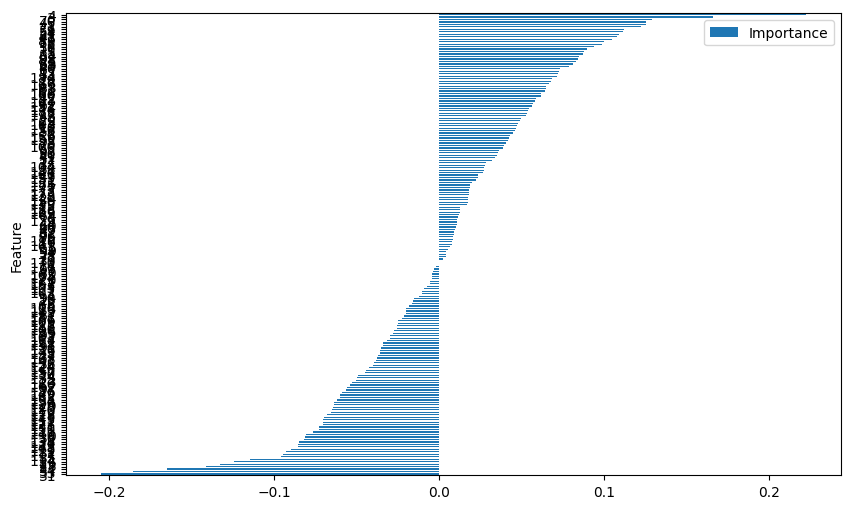

In [ ]:
for name, model_param in model.named_parameters():
    print(name)
    if name == 'linear.weight':
        weights = model_param.data
print(weights)
coefficients = weights.detach().numpy()
feature_importance = pd.DataFrame({'Feature': X_train_df['all'].columns, 'Importance': coefficients.flatten()})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

#### Predictions performances

In [ ]:
pn.Row(base.param.data_set)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d84d5b2b-ea3b-4f1f-b19d-215db4ae64fa': {'version…

In [ ]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    # 'all': {
    #     'data': df_heart,
    #     'already_processed': False,
    # },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [ ]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x']
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=category_to_drop,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=False,
                stand_features=base.stand_features,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
								replace_pb_values={},
        )
        x_features = processed_data.dataframes['X_train']['all']
        y_true = torch.tensor(processed_data.dataframes['y_train'].values)

Processing data
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


In [ ]:
# model.eval()
# y_pred_tensor = torch.squeeze(model(x_features))
# y_pred_round_tensor = y_pred_tensor.round()
# y_pred = y_pred_tensor.detach().numpy()
# y_pred_round = y_pred_round_tensor.detach().numpy()

In [ ]:
y_pred = rf.predict_proba(x_features)[:,1]
y_pred_tensor = torch.from_numpy(y_pred)
y_pred_round = rf.predict(x_features)
y_pred_round_tensor = torch.from_numpy(y_pred_round)

In [ ]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,94.1%,92.7%,95.9%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

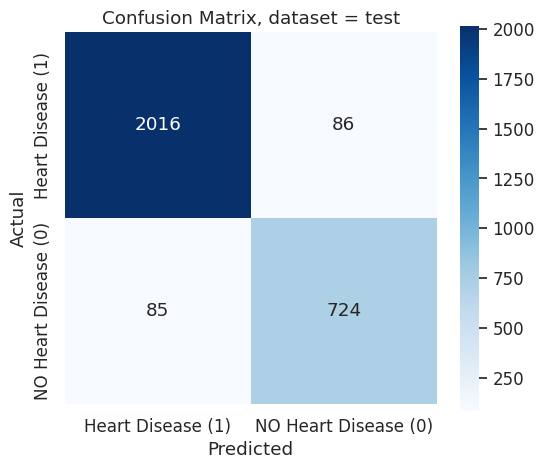

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

In [ ]:
import graph as gr
reload(gr)
import graph as gr

/home/pinolej/eth/healthcare/proj3/task_1/graph.py:300: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/proj3/task_1/graph.py:302: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


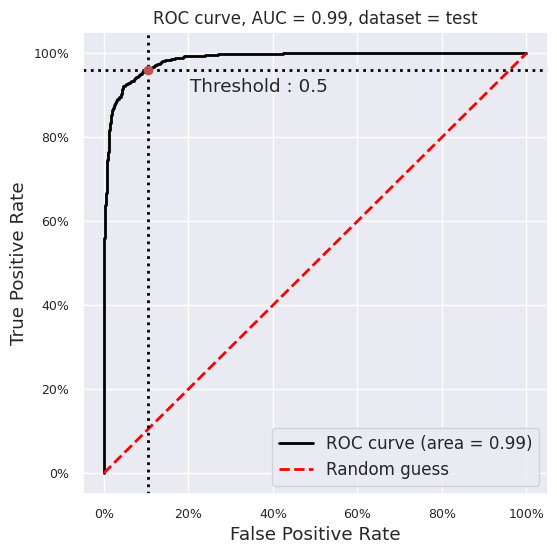

In [ ]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Adding Features Design & Engineering

# Old